#IMAGE CLASSIFICATION MODELS FOR SKIN CANCER DETECTION

To Read: We suggest running the cnn part and the other one separately to avoid RAM crashes with google colab

#Libraries

In [ ]:
# connect to Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import imgaug as ia
from imgaug import augmenters as iaa
import os
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from numpy import asarray
import itertools
import glob
import cv2
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
#from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter

np.random.seed(23072016)

#Load Data


STEP 1: IMPORT DATA

In [ ]:
labels = ['benign', 'malignant']

img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
# import train
train = get_data('/content/drive/MyDrive/Progetto FDS/data/train')

In [ ]:
# import test
test = get_data('/content/drive/MyDrive/Progetto FDS/data/test')

STEP 2: SPLIT LABELS AND FEATURES

In [ ]:
# split the data

x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

In [ ]:
x_train=asarray(x_train)
y_train=asarray(y_train)

x_test=asarray(x_test)
y_test=asarray(y_test)

In [ ]:
# let's do the shuffle
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]

Counter({0: 1438, 1: 1180})

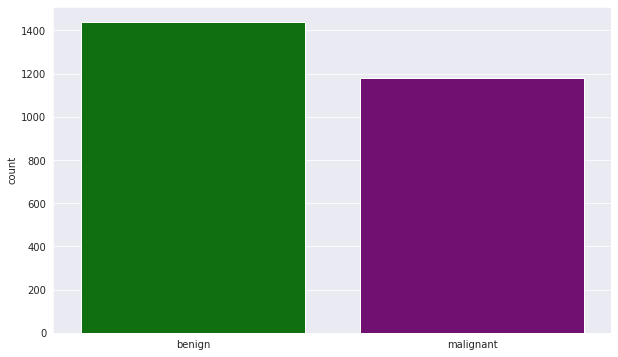

In [ ]:
# let's see what the train set contains

l = []
for i in train:
    if(i[1] == 0):
        l.append("benign")
    else:
        l.append("malignant")
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(10,6))

ax=sns.countplot(l, palette=["green","purple"])

Counter(y_train)

In [ ]:
# before balancing we have to reshape the array
x_train_res = x_train.reshape(2618,3*224*224)

#CNN

#Balancing and One-Hot Encoding


Step 1: Balancing

In [ ]:
# we do balancing through the oversample technique

ros=RandomOverSampler(random_state=42)
x_oversampled, y_oversampled = ros.fit_resample(x_train_res, y_train)

In [ ]:
# we now have the same number of images for each class in the train set
Counter(y_oversampled)

Counter({0: 1438, 1: 1438})

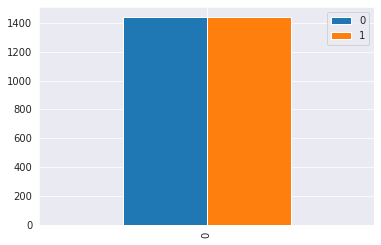

In [ ]:
w= Counter(y_oversampled)
key = w.keys()

df = pd.DataFrame(w,index=key)
df.drop(df.columns[1:], inplace=True)

df.plot(kind='bar')

plt.show()

In [ ]:
# we reshape the array again in order to represent it 
x_oversampled_res=x_oversampled.reshape(2876,224,224,3)

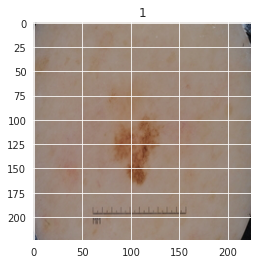

In [ ]:
# let's plot a random image to see if everything is okay 
plt.imshow(x_oversampled_res[2875])
plt.title(y_oversampled[2875])
plt.show()

Step 2: one hot encoding

In [ ]:
y_oversampled

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
y_oversampled = np.asarray(y_oversampled).astype('float32').reshape((-1,1))

In [ ]:
encoder = OneHotEncoder()

one_hot = encoder.fit_transform(y_oversampled) 

print(one_hot.toarray())

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
Y_train=one_hot.toarray()

#Data Augmentation

In [ ]:
# Load the dataset
x_oversampled_res = np.array([ia.imresize_single_image(image, (224, 224)) for image in x_oversampled_res])

# Define the augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flip
    iaa.Crop(percent=(0.1))
])

# Augment the dataset
augmented_images = seq.augment_images(x_oversampled_res)

In [ ]:
# that has the same lenght because for every original image we generate a new image and we put it in augmented_images
len(augmented_images)

2876

In [ ]:
# Concatenate the augmented_images and images arrays along the first axis (axis=0)
X_train = np.concatenate((x_oversampled_res,augmented_images), axis=0)

In [ ]:
X_train.shape

(5752, 224, 224, 3)

In [ ]:
Y_train = np.tile(Y_train, (2, 1))

In [ ]:
# we duplicates also the labels
Y_train.shape

(5752, 2)

# CNN model


Define the model

In [ ]:
def build(input_shape= (224,224,3), lr = 1e-2, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    # Add a set of convolutional layers with filters of size 3x3
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

    # Add a batch normalization layer
    model.add(tf.keras.layers.BatchNormalization())

    # Add a max pooling layer with pool size of 2x2
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    # Add more convolutional and max pooling layers to increase the depth of the network.
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    # Add a flattening layer
    model.add(tf.keras.layers.Flatten())

    # Add fully-connected layers.
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))

    # Add an output layer with softmax activation for classification into two categories (benign or malignant).
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build()

#K-Fold Cross-Validation


Test the performance of our CNN

In [ ]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3)

cvscores = []
for train, test in kfold.split(X_train, Y_train):
  # create model
    model = build()
    
    # Fit the model
    model.fit(X_train, Y_train, batch_size=64
              , epochs=10)
    # evaluate the model
    scores = model.evaluate(X_train[test], Y_train[test], verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    #K.clear_session()
    #del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/10
90/90 [==============================] - 37s 327ms/step - loss: 1.1053 - accuracy: 0.7851
Epoch 2/10
90/90 [==============================] - 26s 284ms/step - loss: 0.4928 - accuracy: 0.8282
Epoch 3/10
90/90 [==============================] - 25s 279ms/step - loss: 0.4024 - accuracy: 0.8449
Epoch 4/10
90/90 [==============================] - 25s 282ms/step - loss: 0.3009 - accuracy: 0.8802
Epoch 5/10
90/90 [==============================] - 25s 282ms/step - loss: 0.2246 - accuracy: 0.9132
Epoch 6/10
90/90 [==============================] - 25s 279ms/step - loss: 0.1827 - accuracy: 0.9345
Epoch 7/10
90/90 [==============================] - 25s 282ms/step - loss: 0.1659 - accuracy: 0.9395
Epoch 8/10
90/90 [==============================] - 25s 282ms/step - loss: 0.1161 - accuracy: 0.9637
Epoch 9/10
90/90 [==============================] - 25s 281ms/step - loss: 0.0774 - accuracy: 0.9774
Epoch 10/10
60/60 [==============================] - 5s 56ms/step - loss: 0.4490 - accuracy

Fit the model

In [ ]:
history=model.fit(X_train, Y_train,
          epochs=15, batch_size= 64
         )

Epoch 1/15
90/90 [==============================] - 25s 282ms/step - loss: 0.0537 - accuracy: 0.9826
Epoch 2/15
90/90 [==============================] - 26s 285ms/step - loss: 0.0583 - accuracy: 0.9849
Epoch 3/15
90/90 [==============================] - 25s 280ms/step - loss: 0.0975 - accuracy: 0.9717
Epoch 4/15
90/90 [==============================] - 25s 280ms/step - loss: 0.0724 - accuracy: 0.9821
Epoch 5/15
90/90 [==============================] - 25s 283ms/step - loss: 0.0593 - accuracy: 0.9837
Epoch 6/15
90/90 [==============================] - 25s 282ms/step - loss: 0.0347 - accuracy: 0.9882
Epoch 7/15
90/90 [==============================] - 25s 280ms/step - loss: 0.0216 - accuracy: 0.9950
Epoch 8/15
90/90 [==============================] - 25s 281ms/step - loss: 0.0078 - accuracy: 0.9977
Epoch 9/15
90/90 [==============================] - 25s 281ms/step - loss: 0.0212 - accuracy: 0.9939
Epoch 10/15
90/90 [==============================] - 25s 280ms/step - loss: 0.0118 - accura

In [ ]:
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
# ONE HOT ENCODING ON Y_TEST

# creating the object of OneHotEncoder
encoder = OneHotEncoder()

# execute the one-hot encoding of datas
one_hot = encoder.fit_transform(y_test) # ONE HOT are the labels

print(one_hot.toarray()) #printing the result

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
Y_test=one_hot.toarray()

In [ ]:
#ACCURACY

y_pred = model.predict(x_test)

y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(Y_test, axis=1)


print(round(accuracy_score(y_pred,y_test),2))
# In the case of an accuracy of 0.86, it means that the model is able to predict the correct outcome in 86% of cases. 
#This is generally considered to be a good level of accuracy.

21/21 [==============================] - 1s 35ms/step
0.86


In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

[[318  42]
 [ 51 249]]


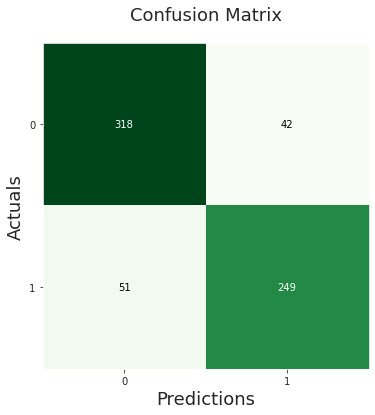

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
#plot the confusion matrix
# TP= 318, FP= 42, FN=51 TN=249

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True) # generate a classification report for a given set of true labels (y_test) and predicted labels (y_pred)
df = pd.DataFrame(report).transpose() 
# The resulting dictionary is then converted into a Pandas DataFrame
# transpose method is called on the resulting DataFrame to rotate it so that the columns and rows are transposed

In [ ]:
df['precision'] = df['precision'].apply('{:.2%}'.format)
df['recall'] = df['recall'].apply('{:.2%}'.format)
df['f1-score'] = df['f1-score'].apply('{:.2%}'.format)
df["support"]=round(df["support"],2)

In [ ]:
df

,precision,recall,f1-score,support
0,86.18%,88.33%,87.24%,360.00
1,85.57%,83.00%,84.26%,300.00
accuracy,85.91%,85.91%,85.91%,0.86
macro avg,85.87%,85.67%,85.75%,660.00
weighted avg,85.90%,85.91%,85.89%,660.00


#SVM and NB

# Normalization and Scaling for SVM and NB



In [ ]:
#NORMALIZATION AND SCALING FOR SVM AND NB 
#TRAINING
import numpy as np

def normalize(images):
    return images / 255

def feature_scale(images):
    mean = np.mean(images, axis=(1, 2, 3))
    std = np.std(images, axis=(1, 2, 3))
    return (images - mean[:, np.newaxis, np.newaxis, np.newaxis]) / std[:, np.newaxis, np.newaxis, np.newaxis]

# Assume that images is a list of RGB images with dimensions (num_images, height, width, 3)
normalized_images = normalize(x_train)
scaled_images = feature_scale(normalized_images)

In [ ]:
rshape = scaled_images.shape[1]*scaled_images.shape[2]*scaled_images.shape[3]
scaled_images_reshaped = scaled_images.reshape(scaled_images.shape[0],rshape)

In [ ]:
#TEST

def normalize(images):
    return images / 255

def feature_scale(images):
    mean = np.mean(images, axis=(1, 2, 3))
    std = np.std(images, axis=(1, 2, 3))
    return (images - mean[:, np.newaxis, np.newaxis, np.newaxis]) / std[:, np.newaxis, np.newaxis, np.newaxis]

# Assume that images is a list of RGB images with dimensions (num_images, height, width, 3)
normalized_images = normalize(x_test)
scaled_images_test = feature_scale(normalized_images)

In [ ]:
rshape = scaled_images_test.shape[1]*scaled_images_test.shape[2]*scaled_images_test.shape[3]
scaled_images_test_reshaped = scaled_images_test.reshape(scaled_images_test.shape[0],rshape)

# SVM classifier

In [ ]:
svm = SVC(kernel='linear')

# train the model on the training data
svm.fit(scaled_images_reshaped, y_train)

SVC(kernel='linear')

In [ ]:
y_pred = svm.predict(scaled_images_test_reshaped)

In [ ]:
print("SVM accuracy score is:",round(accuracy_score(y_pred,y_test),2))

SVM accuracy score is: 0.78


In [ ]:
# y_pred=np.argmax(y_pred, axis=1)
# y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

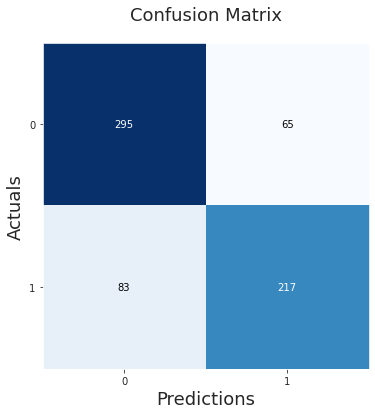

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True) 
df_SVM = pd.DataFrame(report).transpose() 

In [ ]:
df_SVM['precision'] = df_SVM['precision'].apply('{:.2%}'.format)
df_SVM['recall'] = df_SVM['recall'].apply('{:.2%}'.format)
df_SVM['f1-score'] = df_SVM['f1-score'].apply('{:.2%}'.format)
df_SVM["support"]=round(df_SVM["support"],2)
df_SVM

,precision,recall,f1-score,support
0,78.04%,81.94%,79.95%,360.00
1,76.95%,72.33%,74.57%,300.00
accuracy,77.58%,77.58%,77.58%,0.78
macro avg,77.50%,77.14%,77.26%,660.00
weighted avg,77.55%,77.58%,77.50%,660.00


# NAIVE BAYES

In [ ]:
nb = GaussianNB()
nb.fit(scaled_images_reshaped, y_train)

GaussianNB()

In [ ]:
y_prediction_nb = nb.predict(scaled_images_test_reshaped)

In [ ]:
print("NAIVE BAYES accuracy score is:",round(accuracy_score(y_prediction_nb,y_test),2))

NAIVE BAYES accuracy score is: 0.74


In [ ]:
cm_nb = confusion_matrix(y_test, y_prediction_nb)

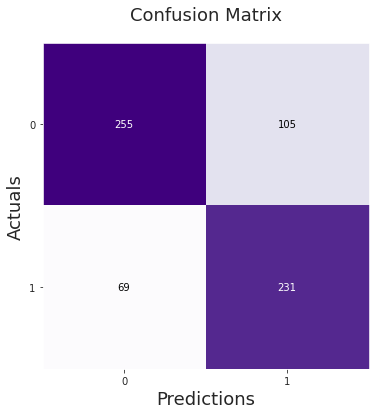

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm_nb, figsize=(6, 6), cmap=plt.cm.Purples)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# classifica malino i tumori benigni

In [ ]:
report = classification_report(y_test, y_prediction_nb, output_dict=True) 
df_NB = pd.DataFrame(report).transpose() 

In [ ]:
df_NB['precision'] = df_NB['precision'].apply('{:.2%}'.format)
df_NB['recall'] = df_NB['recall'].apply('{:.2%}'.format)
df_NB['f1-score'] = df_NB['f1-score'].apply('{:.2%}'.format)
df_NB["support"]=round(df_NB["support"],2)
df_NB

,precision,recall,f1-score,support
0,78.70%,70.83%,74.56%,360.00
1,68.75%,77.00%,72.64%,300.00
accuracy,73.64%,73.64%,73.64%,0.74
macro avg,73.73%,73.92%,73.60%,660.00
weighted avg,74.18%,73.64%,73.69%,660.00
